# Hotel Booking cancelation

# Setup

First, we import some few library for malipulate and visualize the data of cancelation of hotel in Portugal

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the data and manipulate

In [64]:
data = pd.read_csv(r"C:\Users\Admin\Data python\data_all\data_all\train.csv")
pd.set_option('display.max_columns', 32)
data.head()

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
0,1,Resort Hotel,0,1,0,1,2,0.0,1,BB,PRT,Direct,Direct,0,0,0,A,A,1,250.0,0.0,0,Transient,55.00,1,0,2017-02-04
1,2,Resort Hotel,0,1,0,2,1,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,D,0,0.0,0.0,0,Transient,40.00,0,0,2016-03-04
2,3,City Hotel,1,56,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,29.0,0.0,0,Transient,60.00,0,0,2017-02-01
3,4,City Hotel,0,213,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,9.0,0.0,0,Transient,102.85,0,1,2016-10-05
4,5,Resort Hotel,0,328,4,10,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,D,D,0,243.0,0.0,0,Contract,121.50,0,2,2017-06-29


We can see that it have many column, we need deep dive in each of them to know exactly its data structure for feature engineering 

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108785 entries, 0 to 108784
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              108785 non-null  int64  
 1   hotel                           108785 non-null  object 
 2   is_canceled                     108785 non-null  int64  
 3   lead_time                       108785 non-null  int64  
 4   stays_in_weekend_nights         108785 non-null  int64  
 5   stays_in_week_nights            108785 non-null  int64  
 6   adults                          108785 non-null  int64  
 7   children                        108785 non-null  float64
 8   babies                          108785 non-null  int64  
 9   meal                            108785 non-null  object 
 10  country                         108785 non-null  object 
 11  market_segment                  108785 non-null  object 
 12  distribution_cha

In [66]:
# Conver arrival date to timeseires
data["arrival_date"] = data["arrival_date"].apply(pd.to_datetime)

# Set arrival_date column as index
data = data.sort_values(by = ["arrival_date"])

## Explain column meaning

**hotel**：City hotel hoặc Resort Hotel

**lead_time**：Số ngày từ khi đặt phòng đến ngày nghỉ trọ.

**stays_in_weekend_nights**：Số ngày đặt phòng và nghỉ lại (Thứ 7, Chủ Nhật)

**stays_in_week_nights**：Số ngày đặt phòng và nghỉ lại (Thứ 2 ~ Thứ 6)

**country**：Quốc gia.

**market_segment**：Phân loại thị trường(TA：Đại lý du lịch、TO：Điều hành du lịch)

**distribution_channel**：kênh cung cấp(TA：Đại lý du lịch、TO：Điều hành du lịch)

**is_repeated_guest**：có phải repeater hay không

**previous_cancellations**：Đã từng hủy đặt phòng trước đây

**previous_bookings_not_canceled**：chưa từng hủy đặt phòng trước đây

**reserved_room_type**：Loại phòng đặt

**assigned_room_type**：Loại phòng sắp xếp

**booking_changes**：Số lần thay đổi đặt phòng

**agent**：ẩn

**company**：ẩn

**days_in_waiting_list**：Số ngày lấy được xác nhận của khách hàng.

**customer_type**：loại khách hàng

**adr**：Tỉ giá trung bình ngày nghỉ trọ

**required_car_parking_spaces**：Yêu cầu bao nhiêu chỗ đỗ xe

**total_of_special_requests**：Số lượng yêu cầu đặc biệt.

*Đây là bộ dữ liệu trích xuất từ hệ thống Quản lý khách sạn (PMS), vì thế tên khách sạn và đại lý đặt phòng sẽ được ẩn 
đi.*

### Explain for meal

**RO**: Room only

**BB**: Bed & Breakfast

**HB**: Half Board (Breakfast and Dinner normally)

**FB**: Full Board (Beakfast, Lunch and Dinner)

**AI**: All Inclusive (all services of full board plus any others specified in each case)

That was so many column, we can see that have 2 type of column. It is categorical and continuous column. 
With categorical data, i will use OneHotEncode, and with continuous variables i will specify it distribution to know its structure

The company and the agent have been hidden so it don't have many impact to the data, Id just indicate like index. Column hotel don't sketch any clear picture, it just city hotel and resort, it isn't too meaningful, but important if our project aim at predict at each hotel data come from. 'arrival_date' column just show time the guest comming which is crucial for time analyst we will do it later

In [67]:
col = ['agent', 'company', 'id']

hotel_book = data.drop(col, axis= 1)

# Examine the data structre and clear the outlier 

## Let deep dive to the categorical variables first

Take a look at all variables categorical data and know how many values each variables

In [68]:
# Categorical data
col = ['meal', 'country',"market_segment", 'distribution_channel', 'reserved_room_type', 'assigned_room_type',"customer_type"]

for i in hotel_book[col]:
    x = hotel_book[i].value_counts()
    print("Column name is:",i,"and it value is:",x)
    print()

Column name is: meal and it value is: BB    85099
HB    12705
SC    10238
FB      743
Name: meal, dtype: int64

Column name is: country and it value is: PRT    45865
GBR    10764
FRA     9498
ESP     7614
DEU     6387
       ...  
KIR        1
ASM        1
SDN        1
MRT        1
SMR        1
Name: country, Length: 173, dtype: int64

Column name is: market_segment and it value is: Online TA        49545
Offline TA/TO    22682
Groups           19354
Direct           11196
Corporate         5079
Complementary      697
Aviation           230
Undefined            2
Name: market_segment, dtype: int64

Column name is: distribution_channel and it value is: TA/TO        88940
Direct       13203
Corporate     6449
GDS            188
Undefined        5
Name: distribution_channel, dtype: int64

Column name is: reserved_room_type and it value is: A    79728
D    16771
E     5708
F     2536
G     1796
B     1041
C      689
H      510
L        6
Name: reserved_room_type, dtype: int64

Column name 

**meal country**:5

**market_segment**: 177

**market_segment**: 8 

**distribution_channel**: 5 

**reserved_room_type**: 9

**assigned_room_type**: 11

**deposit_type**: 3

**customer_type**: 4

we can see that market_segment and distribution_channel and undefined values and it one have 7 values in order to make make it no affected to the others values so i decide to remove undefined as an outlier of data

In [69]:
# Take the index of the value we want
index_drop3 = list(hotel_book[(hotel_book['market_segment'] == 'Undefined') & 
                               (hotel_book['distribution_channel'] == 'Undefined')].index)

hotel_book = hotel_book.drop(index_drop3, axis = 0)

## Now let let take a look at continuous variables

In [70]:
hotel_book.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000,108783.000000
mean,0.370674,100.161661,0.909453,2.464962,1.845252,0.092377,0.007952,0.032542,0.094408,0.136961,0.211752,2.540296,97.086916,0.063098,0.544221
std,0.482987,104.953242,0.992508,1.887036,0.582489,0.377312,0.098158,0.177435,0.881887,1.448237,0.626868,18.401677,46.909768,0.246520,0.777143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,17.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.500000,0.000000,0.000000
50%,0.000000,65.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000
75%,1.000000,152.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,0.000000,1.000000
max,1.000000,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,67.000000,18.000000,391.000000,5400.000000,8.000000,5.000000


we can see adr column that the max of adr is 5400 is too far from distribution maybe its a mistake of typing of employee of some error of system. 

And min adr is -6.38 which adr is Average Daily Rate which must be bigger than zero which mean zero or smaller is not appropriate in this case so we will remove them.

Columns "stays_in_weekend_nights" and 'stays_in_week_nights' has value is zero, this column mean the day the book, thus, it have to be non zero value so we will remove row which both column is zero. The adult column is so on, we can't booking with adult is zero se we will remove that row too.

In [71]:
# Index of 2 column day guest stay must be > 0
index1 = list(hotel_book[(hotel_book["stays_in_weekend_nights"] == 0) & 
                    (hotel_book["stays_in_week_nights"] == 0)].index)
# Index of adr which must be > 0
index2 = list(hotel_book[hotel_book["adr"] <= 0].index)

# Index
index3 = list(hotel_book[hotel_book["adults"] == 0].index)

index = index1 + index2 + index3

In [72]:
hotel_book = hotel_book.drop(index)
hotel_book

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
99333,Resort Hotel,0,77,2,5,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,94.0,0,0,2015-07-01
65119,City Hotel,0,257,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,0,Transient,101.5,0,0,2015-07-01
83081,City Hotel,1,181,1,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,1,0,A,A,0,0,Transient,76.5,0,0,2015-07-01
30704,City Hotel,0,181,1,4,3,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,111.5,0,0,2015-07-01
50884,City Hotel,0,257,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,0,Transient,101.5,0,0,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78230,City Hotel,0,225,0,3,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,95.7,0,3,2017-06-29
28994,City Hotel,0,152,2,5,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,0,0,Transient,80.1,0,1,2017-06-29
78605,Resort Hotel,0,138,0,2,2,1.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,D,0,0,Transient,117.3,1,1,2017-06-29
70776,City Hotel,0,19,0,2,1,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,120.0,0,1,2017-06-29


I try using Gaussian Mixture Model to clear instance which consider as outlier of data. I remove 5% of data at low density

In [73]:
from sklearn.mixture import GaussianMixture

gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42, verbose = 2).fit(hotel_book_one_hot)
             for k in range(1, 8)]

Initialization 0
Initialization converged: True	 time lapse 3.82151s	 ll 551.02686
Initialization 1
Initialization converged: True	 time lapse 4.03498s	 ll 551.02686
Initialization 2
Initialization converged: True	 time lapse 4.33799s	 ll 551.02686
Initialization 3
Initialization converged: True	 time lapse 4.41920s	 ll 551.02686
Initialization 4
Initialization converged: True	 time lapse 4.04075s	 ll 551.02686
Initialization 5
Initialization converged: True	 time lapse 4.32863s	 ll 551.02686
Initialization 6
Initialization converged: True	 time lapse 4.39908s	 ll 551.02686
Initialization 7
Initialization converged: True	 time lapse 4.28067s	 ll 551.02686
Initialization 8
Initialization converged: True	 time lapse 4.53998s	 ll 551.02686
Initialization 9
Initialization converged: True	 time lapse 4.26654s	 ll 551.02686
Initialization 0
Initialization converged: True	 time lapse 27.31323s	 ll 888.28778
Initialization 1
Initialization converged: True	 time lapse 26.45905s	 ll 888.28778
In

KeyboardInterrupt: 

Using BICS and AICS to evaluate the cluster of data

In [ ]:
bics = [model.bic(hotel_book_one_hot) for model in gms_per_k]
aics = [model.aic(hotel_book_one_hot) for model in gms_per_k]

Plot the AICS and BÍC to see the result when we increasing the cluster 

In [ ]:
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(figsize = (12, 8))
    adr.plot(ax = ax)
    ax.set(ylabel = 'Average rate per night')
    for index,data in enumerate(adr["City Hotel"]):
         ax.text(x= index + 0.6, y = data, s=f"{round(data, 2)}" , fontdict=dict(fontsize=12))
    for index,data in enumerate(adr["Resort Hotel"]):
         ax.text(x= index + 0.6, y = data, s=f"{round(data, 2)}" , fontdict=dict(fontsize=12))
    for index,data in enumerate(adr["Total"]):
         ax.text(x= index + 0.6, y = data, s=f"{round(data, 2)}" , fontdict=dict(fontsize=12))

<img src="bic.png" width="600" height="350">

we can see that k > 2 don't change too much value with k = 2 so we choose k = 2 and init = 10 for speed of algorithm

Before using Gaussian Mixture we have to use Onehotencode to data

In [74]:
# Drop Hotel and arrival date to use GM
col = ["hotel", "arrival_date"]
hotel_book_drop = hotel_book.drop(col, axis = 1)

In [75]:
cat_attri = ['meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', "customer_type"]

one_hot = pd.get_dummies(hotel_book_drop[cat_attri])
hotel_book_drop = hotel_book_drop.drop(cat_attri, axis = 1)
# Join the encoded df
hotel_book_one_hot = hotel_book_drop.join(one_hot)
hotel_book_one_hot

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,...,reserved_room_type_L,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
99333,0,77,2,5,2,0.0,0,0,0,0,0,0,94.0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
65119,0,257,0,2,2,0.0,0,0,0,0,0,0,101.5,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
83081,1,181,1,4,2,0.0,0,0,1,0,0,0,76.5,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
30704,0,181,1,4,3,0.0,0,0,0,0,0,0,111.5,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
50884,0,257,0,2,2,0.0,0,0,0,0,0,0,101.5,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78230,0,225,0,3,2,0.0,0,0,0,0,0,0,95.7,0,3,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
28994,0,152,2,5,2,0.0,0,0,0,0,0,0,80.1,0,1,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
78605,0,138,0,2,2,1.0,0,0,0,0,0,0,117.3,1,1,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
70776,0,19,0,2,1,0.0,0,0,0,0,0,0,120.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Remove outlier which is 3% in low density

In [76]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components = 2, n_init = 10)

gm.fit(hotel_book_one_hot)

densities = gm.score_samples(hotel_book_one_hot)

density_thresholds = np.percentile(densities, 3)

hotel_book_cleaned = hotel_book_one_hot[densities > density_thresholds]

In [77]:
hotel_book_cleaned.shape

(103634, 228)

Let see our data again

In [78]:
hotel_book_cleaned.describe()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,...,reserved_room_type_L,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,...,103634.0,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.000000,103634.0,103634.000000,103634.000000,103634.000000,103634.000000
mean,0.379345,102.194936,0.917585,2.484773,1.853156,0.086545,0.007546,0.028408,0.094689,0.107445,0.203157,2.574146,98.360196,0.062663,0.540296,0.781732,...,0.0,0.634956,0.016549,0.018633,0.211745,0.064400,0.030202,0.017842,0.004940,0.000550,0.000183,0.0,0.036310,0.003300,0.741764,0.218625
std,0.485226,105.533971,0.986741,1.862825,0.470849,0.361897,0.087976,0.166135,0.889003,1.031705,0.604142,18.502030,42.442455,0.243667,0.773976,0.413072,...,0.0,0.481445,0.127573,0.135225,0.408547,0.245465,0.171145,0.132376,0.070115,0.023446,0.013539,0.0,0.187062,0.057352,0.437666,0.413316
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.830000,0.000000,0.000000,1.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,68.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.550000,0.000000,0.000000,1.000000,...,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,1.000000,155.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,0.000000,1.000000,1.000000,...,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,1.000000,709.000000,16.000000,40.000000,4.000000,3.000000,2.000000,1.000000,26.000000,45.000000,16.000000,391.000000,508.000000,3.000000,5.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


## Checking Nan value

Check if any value is is Nan

In [79]:
hotel_book_cleaned.isnull().any()

is_canceled                      False
lead_time                        False
stays_in_weekend_nights          False
stays_in_week_nights             False
adults                           False
                                 ...  
assigned_room_type_L             False
customer_type_Contract           False
customer_type_Group              False
customer_type_Transient          False
customer_type_Transient-Party    False
Length: 228, dtype: bool

Great! it don't have nan value

# Analysis and visualize data

1. How many bookings were canceled?
2. Which month has the highest number of visitors?
3. What is the monthly average daily rate per person over the year?
4. Which country has the most number of hotel visitors?
5. Which customer type contributes to the most hotel booking cancellations?
6. Which month has the highest number of cancellations?

## How many bookings were canceled?

In [80]:
# Make a list of index to indexing
a = list(hotel_book_cleaned.index)

In [81]:
hotel_plot = hotel_book.loc[a, :]
hotel_plot

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
99333,Resort Hotel,0,77,2,5,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,94.0,0,0,2015-07-01
65119,City Hotel,0,257,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,0,Transient,101.5,0,0,2015-07-01
83081,City Hotel,1,181,1,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,1,0,A,A,0,0,Transient,76.5,0,0,2015-07-01
30704,City Hotel,0,181,1,4,3,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,111.5,0,0,2015-07-01
50884,City Hotel,0,257,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,0,Transient,101.5,0,0,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78230,City Hotel,0,225,0,3,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,95.7,0,3,2017-06-29
28994,City Hotel,0,152,2,5,2,0.0,0,BB,GBR,Offline TA/TO,TA/TO,0,0,0,A,A,0,0,Transient,80.1,0,1,2017-06-29
78605,Resort Hotel,0,138,0,2,2,1.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,D,0,0,Transient,117.3,1,1,2017-06-29
70776,City Hotel,0,19,0,2,1,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,0,Transient,120.0,0,1,2017-06-29


In [82]:
barplot = hotel_plot.copy()

barplot['guests'] = barplot['adults'] + barplot['children'] + barplot['babies']

col = ["is_canceled", "guests", "hotel"]

barplot = barplot[col].groupby(['hotel',"is_canceled"]).sum().reset_index()
barplot

,hotel,is_canceled,guests
0,City Hotel,0,75535.0
1,City Hotel,1,57810.0
2,Resort Hotel,0,48560.0
3,Resort Hotel,1,19896.0


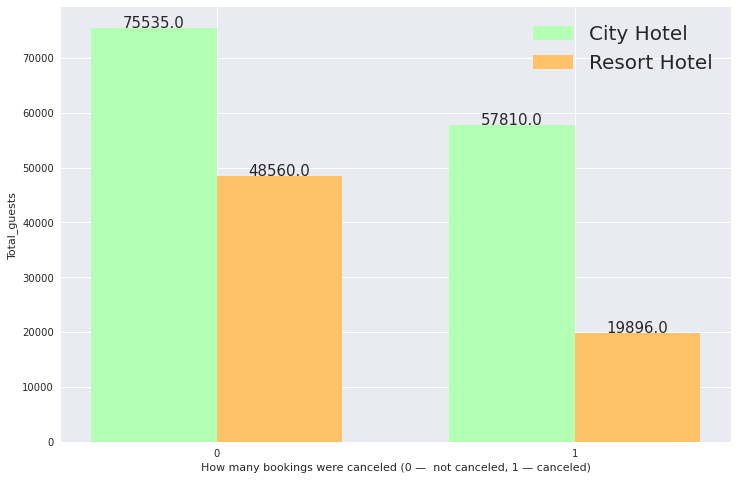

In [83]:
ind = np.arange(2)

with plt.style.context("seaborn"):
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.bar(ind, barplot[0:2]["guests"], width = 0.35, color='#b3ffb3', label = "City Hotel")
    ax.bar(ind + 0.35, barplot[2:4]["guests"], width = 0.35, color='#ffc266', label = "Resort Hotel")
    ax.set(xlabel = "How many bookings were canceled (0 —  not canceled, 1 — canceled)", ylabel = "Total_guests")
    ax.legend(prop={'size': 20})
    ax.set_xticks(ind + 0.35 / 2)
    ax.set_xticklabels(('0', '1'))
    for index,data in enumerate(barplot[0:2]["guests"]):
         ax.text(x= index , y = data+1 , s=f"{data}" , fontdict=dict(fontsize=15), ha = "center")
    for index,data in enumerate(barplot[2:4]["guests"]):
         ax.text(x= index + 0.35, y = data+1 , s=f"{data}" , fontdict=dict(fontsize=15), ha = "center")

## Which month has the highest number of visitors?

In [84]:
# Copy to a new dataframe
lineplot = hotel_plot.copy()

# Add one to each row 
a = np.ones(len(lineplot["hotel"]), dtype = int)

# Add new column to df
lineplot['count'] = list(a)

# Take column we want
lineplot = lineplot[["count", "arrival_date", 'hotel']]

# Set arrival_date column as index
lineplot = lineplot.sort_values(by =  ["arrival_date"]).set_index("arrival_date")

# Group by month(The month as January=1, December=12)
monthly = lineplot.groupby([lineplot.index.month, 'hotel']).sum()

In [85]:
# Create pivot table
monthly = pd.pivot_table(monthly, values='count', index = "arrival_date", columns="hotel")
# Add column total
monthly["total"] = monthly["City Hotel"] + monthly["Resort Hotel"] 
monthly

hotel,City Hotel,Resort Hotel,total
arrival_date,,,
1,3457,2076,5533
2,4702,2993,7695
3,6123,3209,9332
4,7114,3467,10581
5,7827,3412,11239
6,7393,2844,10237
7,4339,2707,7046
8,5627,3004,8631
9,7104,2959,10063


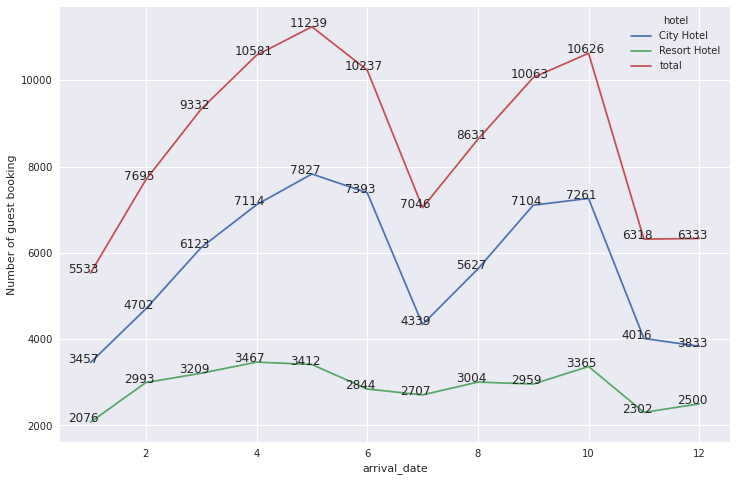

In [86]:
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(figsize = (12, 8))
    monthly.plot(ax = ax)
    ax.set(ylabel = 'Number of guest booking')
    for index,data in enumerate(monthly["City Hotel"]):
         ax.text(x= index + 0.6, y = data, s=f"{data}" , fontdict=dict(fontsize=12))
    for index,data in enumerate(monthly["Resort Hotel"]):
         ax.text(x= index + 0.6, y = data, s=f"{data}" , fontdict=dict(fontsize=12))
    for index,data in enumerate(monthly["total"]):
         ax.text(x= index + 0.6, y = data, s=f"{data}" , fontdict=dict(fontsize=12))

We can see that on May, was the hightest month which people want to arrival. And people prefer to booking at City Hotel rather than Resort Hotel

## What is the monthly average daily rate per preservation over the year?

In [87]:
# Copy data
adr = hotel_plot.copy()
# Take column we wanna use
col = ["adr", 'arrival_date', 'hotel']
# Set index
adr = adr[col].set_index('arrival_date')
# Take the mean of average per night
adr = adr.groupby([adr.index.month, 'hotel']).mean()
# Creat a pivot table
adr = pd.pivot_table(adr, values='adr', index = "arrival_date", columns="hotel")
# Add column total
adr["Total"] = adr["City Hotel"] + adr["Resort Hotel"]
adr

hotel,City Hotel,Resort Hotel,Total
arrival_date,,,
1,84.127579,50.828752,134.956331
2,86.624209,56.054721,142.678930
3,92.764227,58.578333,151.342560
4,112.097987,78.984589,191.082576
5,122.934481,80.121433,203.055914
6,119.957235,110.713221,230.670456
7,100.215446,142.945157,243.160603
8,103.192906,176.388249,279.581155
9,111.341418,94.135171,205.476588


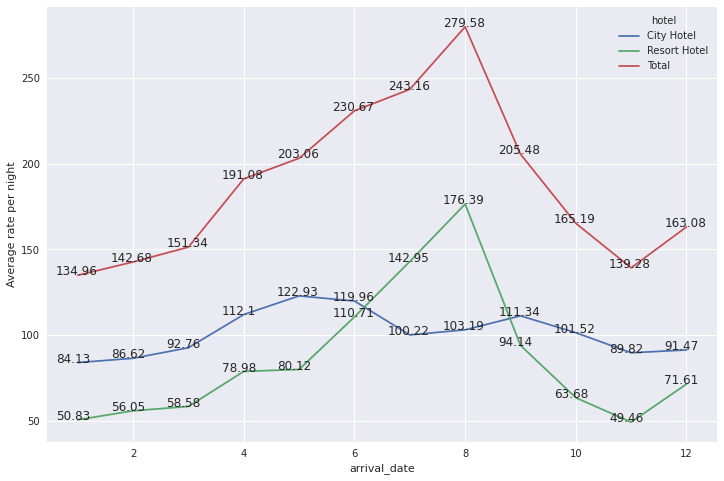

In [88]:
with plt.style.context("seaborn"):
    fig, ax = plt.subplots(figsize = (12, 8))
    adr.plot(ax = ax)
    ax.set(ylabel = 'Average rate per night')
    for index,data in enumerate(adr["City Hotel"]):
         ax.text(x= index + 0.6, y = data, s=f"{round(data, 2)}" , fontdict=dict(fontsize=12))
    for index,data in enumerate(adr["Resort Hotel"]):
         ax.text(x= index + 0.6, y = data, s=f"{round(data, 2)}" , fontdict=dict(fontsize=12))
    for index,data in enumerate(adr["Total"]):
         ax.text(x= index + 0.6, y = data, s=f"{round(data, 2)}" , fontdict=dict(fontsize=12))

# Looking for corralation

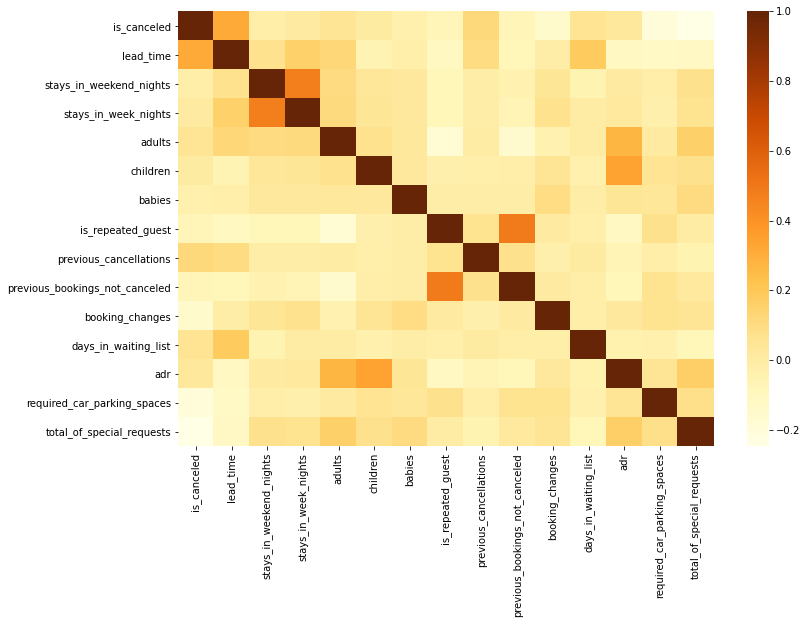

In [89]:
fig, ax = plt.subplots(figsize = (12, 8))
ax = sns.heatmap(hotel_plot.corr(), cmap = "YlOrBr")

We can see that lead_time has strong corralation with is_canceled

# Prepare data for machine learning

Split data to trainning instances and label

In [90]:
x_train = hotel_book_cleaned.drop(['is_canceled'], axis = 1)
y_train = hotel_book_cleaned['is_canceled'].copy()

Scale the data 

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

col_num = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
           'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr',
           'required_car_parking_spaces', 'total_of_special_requests'
          ]

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), col_num)
], remainder = "passthrough")

X_train_prepared = full_pipeline.fit_transform(x_train)

I using PCA to reduce the feature to train, preserve 95% variance of the data

In [92]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)

X_train_reduced = pca.fit_transform(X_train_prepared)

let see how many feature have been reduced

In [93]:
X_train_reduced.shape

(103634, 72)

Down from 228 t0 82, its about 64% of the feature have been remove

Define a function to evaluate the model. I mainly use Area under the curve to evaluate the model but also using confusion matrix to know how accuration the model predict (the precision score and recal score)

In [94]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, precision_score, recall_score

def EvalROCcurve_Plot(model, X, Y, cv = 5, method = "decision_function", 
                      styleplot = "seaborn", titleplot1 = None, titleplot2 = None):
    # Caculate score 
    result1 = cross_val_score(model, X, Y, scoring = "accuracy", cv = cv)
    # Caculate confusion matrix
    result2 = cross_val_predict(model, X, Y, cv = cv)
    # Evaluate using cross_val_predict
    y_s = cross_val_predict(model, X, Y, cv = cv, method = method, verbose = 2)
    # Choose column if method is predict proba
    if (method == "predict_proba"):
        y_score = y_s[:, 1]
    else:
        y_score = y_s
    # Caculate precision, recall and thresholds
    precisions, recalls, thresholds1 = precision_recall_curve(Y, y_score)
    # Caculate ROC AUC
    RocAucScore = roc_auc_score(Y, y_score)
    fpr, tpr, thresholds2 = roc_curve(Y, y_score)
    with plt.style.context(styleplot):
        fig, ax = plt.subplots(2, 1, figsize = (13, 10))
        # Plot Roc_curve
        ax[0].plot(fpr, tpr, linewidth = 2)
        ax[0].plot([0, 1], [0, 1], "k--")
        ax[0].set(xlabel = "False Positive Rate", ylabel  = "Recall", title = titleplot1)
        # Plot precision and recall curve
        ax[1].plot(thresholds1, precisions[:-1], "b--", label = "Precision", linewidth = 2)
        ax[1].plot(thresholds1, recalls[:-1], "g--", label = "Recall", linewidth = 2)
        ax[1].set(xlabel = "Thresholds", title = titleplot2)
        ax[1].legend(prop={'size': 15})
    # Save confu matrix result
    tn = confusion_matrix(Y, result2).ravel()
    # Print the result
    print("score_accuracy:", result1)
    print("confu_matrix:", confusion_matrix(Y, result2))
    print("precision_score:", precision_score(Y, result2))
    print("recall_score:", recall_score(Y, result2))
    print("ROC AUC:", RocAucScore)
    return fpr, tpr, thresholds1, tn

First let start using SGD to classify this data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.0s finished
score_accuracy: [0.842476   0.80986153 0.7626767  0.77396632 0.78225417]
confu_matrix: [[56387  7934]
 [13389 25924]]
precision_score: 0.7656683797034675
recall_score: 0.6594256352860377
ROC AUC: 0.8629042478959299


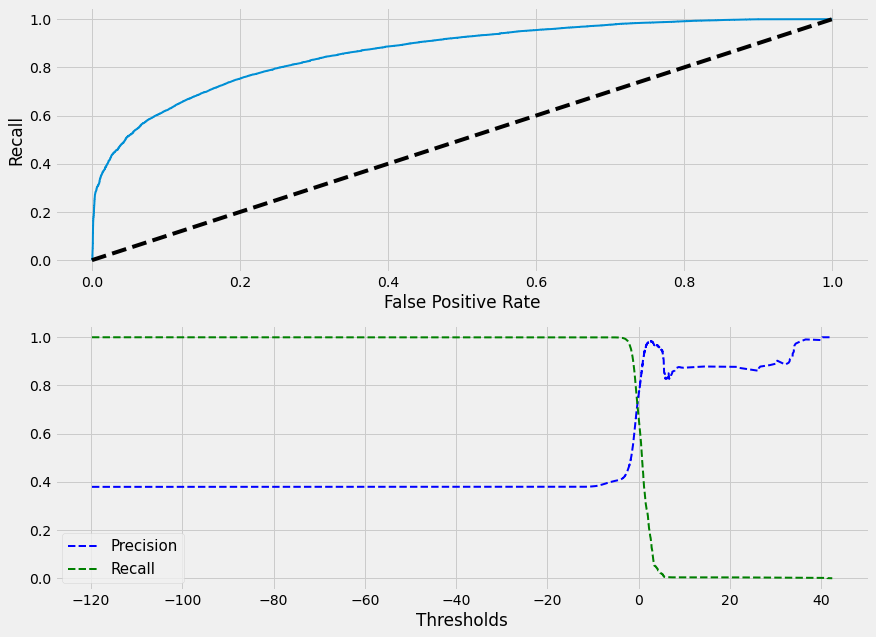

In [95]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)

sgd_eval = EvalROCcurve_Plot(sgd_clf, X_train_reduced, y_train, styleplot = "fivethirtyeight")

We can see AUC is 0.865. the precision is quit good but recall is not quite that so we will change to more complexity model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished
score_accuracy: [0.80156318 0.83620399 0.80672553 0.77681285 0.7829779 ]
confu_matrix: [[58155  6166]
 [14472 24841]]
precision_score: 0.8011416776856839
recall_score: 0.6318774959936917
ROC AUC: 0.8654325192169336


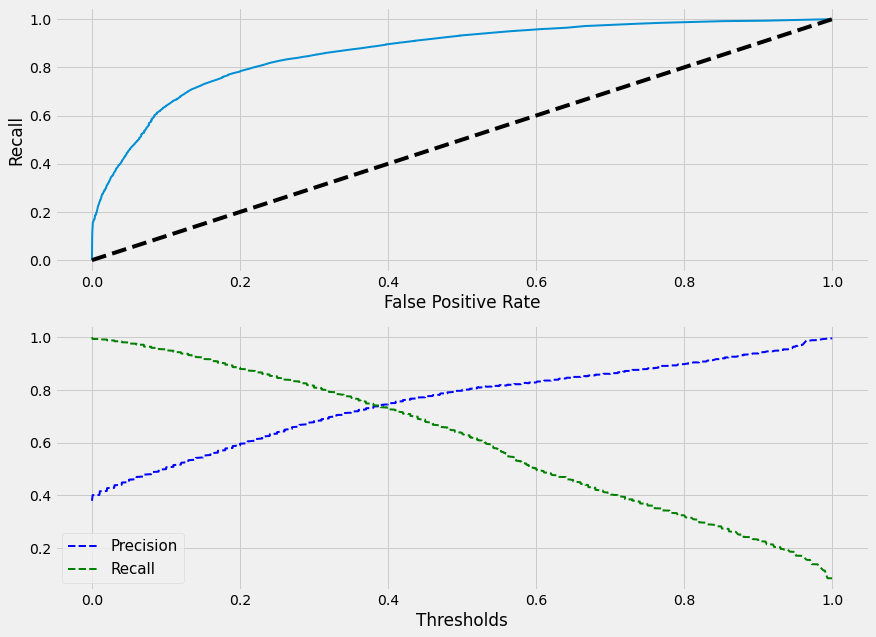

In [96]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42)

rand_forest_roc = EvalROCcurve_Plot(random_clf, X_train_reduced, y_train, method = "predict_proba", styleplot = "fivethirtyeight")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 17.1min finished
score_accuracy: [0.80041684 0.83048362 0.79064382 0.795044  ]
confu_matrix: [[57680  6641]
 [13656 25657]]
precision_score: 0.7943835531611865
recall_score: 0.6526339887568997
ROC AUC: 0.8815856587207895


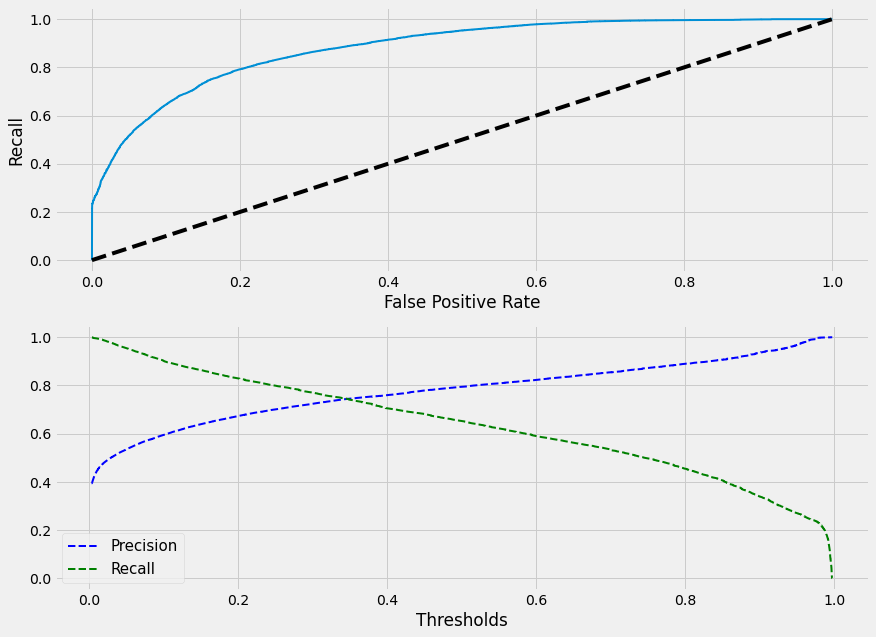

In [97]:
from sklearn.ensemble import GradientBoostingClassifier

gra_clf = GradientBoostingClassifier(max_features = 25, max_leaf_nodes = 700, 
    max_depth = 12, min_samples_leaf = 14, random_state = 42, min_samples_split = 20, n_estimators = 105)

gra_boost = EvalROCcurve_Plot(gra_clf, X_train_reduced, y_train, cv = 4, method = "predict_proba", styleplot = "fivethirtyeight")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.3min finished
score_accuracy: [0.80339654 0.83041444 0.8000193  0.77753655 0.79619801]
confu_matrix: [[60059  4262]
 [16308 23005]]
precision_score: 0.8436938423735652
recall_score: 0.5851753872764734
ROC AUC: 0.8847017518574416


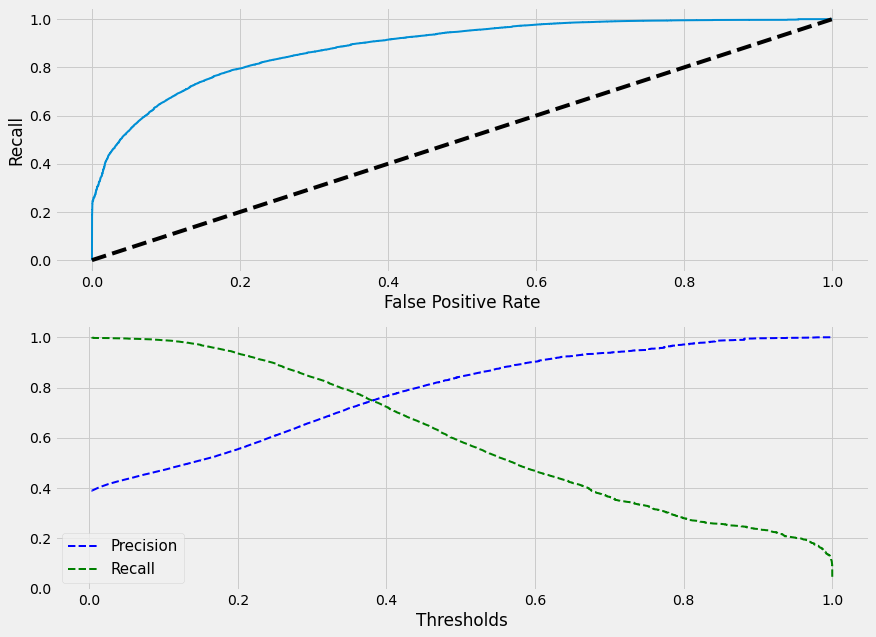

In [99]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(max_features = 40, max_leaf_nodes = 600, 
    max_depth = 11, min_samples_leaf = 14, random_state = 42, min_samples_split = 20, n_estimators = 105, 
    criterion = 'entropy')

rand_forest = EvalROCcurve_Plot(random_clf, X_train_reduced, y_train, method = "predict_proba", styleplot = "fivethirtyeight")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished
score_accuracy: [0.82201959 0.84464708 0.82177836 0.79307184 0.805124  ]
confu_matrix: [[58124  6197]
 [12734 26579]]
precision_score: 0.8109287283378082
recall_score: 0.676086790629054
ROC AUC: 0.8914049324582424


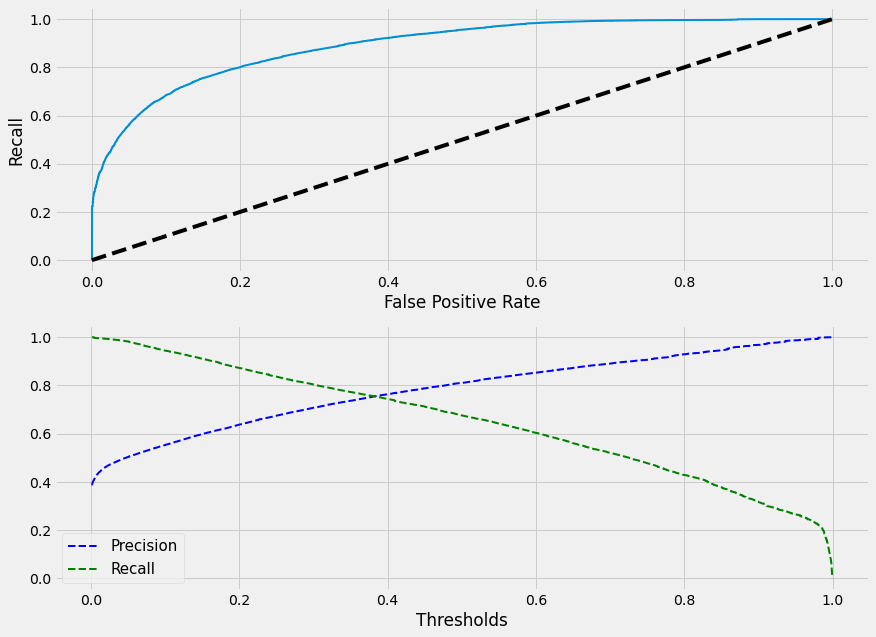

In [117]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_jobs = 2, subsample = 0.7, reg_lambda = 1.1, 
    max_depth = 8, min_child_weight = 0.5, random_state = 42, learning_rate = 0.1, 
    n_estimators = 125, colsample_bytree = 0.8, colsample_bylevel = 0.7, colsample_bynode = 0.7
)

xgb1 = EvalROCcurve_Plot(xgb_clf, X_train_reduced, y_train, method = "predict_proba", styleplot = "fivethirtyeight")